__Group Name__ : __Data Dynamo__
1. Roy, Abhijith; `abhijithroy.roy@carelon.com`,
2. Acharya, Ananth; `ananth.acharya@carelon.com`; 
3. Kumar, Diwakar; `diwakar.kumar@carelon.com`; 
4. Gouse, Mohammad; `mohammad.gouse@carelon.com`;
5. Peketi, Santhosh; `santhosh.peketi@carelon.com`, 

# Assignment 6 - Summarization 



## Objective
- Implement prompt tuning on a GPT-2 small model using PyTorch and fine-tune it
on summarization, 

In [1]:
#importing required libraries for the  task.....
import numpy as np 
import pandas as pd 

import nltk
from nltk.translate.bleu_score import sentence_bleu

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer,AdamW
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset
from tqdm import tqdm
import wandb

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setup


In [2]:
np.object = object

#### Ensure you have the necessary datasets the task. 

In [3]:
#reading dataset from hub.....
dataset = load_dataset("ccdv/cnn_dailymail","3.0.0")

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/ccdv___cnn_dailymail/3.0.0/3.0.0/0107f7388b5c6fae455a5661bcd134fc22da53ea75852027040d8d1e997f101f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
#datset..
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


In [5]:
#sample selecting dataset from huge-corpus....
train_dataset = dataset['train'].shuffle(seed=42).select(range(2871))
test_dataset  = dataset['test'].shuffle(seed=42).select(range(133))
val_dataset  = dataset['validation'].shuffle(seed=42).select(range(114))

#### Use the transformers library from Hugging Face to load the GPT-2 small model and tokenizer. 

In [6]:
# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Define a pad token and add it to the tokenizer
pad_token = tokenizer.eos_token
tokenizer.add_tokens([pad_token])

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

0

In [7]:
#method for tokenization and padding.....
def tokenize_and_pad(data_list, max_article_length=1021, max_highlights_length=1024):
    input_ids = []
    output_ids = []
    for article, highlights in zip(data_list['article'],data_list['highlights']):
        # Tokenize and convert to indices
        article_tokens = tokenizer.encode(article, add_special_tokens=True)
        highlights_tokens = tokenizer.encode(highlights, add_special_tokens=True)

        # Pad sequences to specified lengths
        padded_article_tokens = torch.tensor(article_tokens + [tokenizer.convert_tokens_to_ids(pad_token)] * (max_article_length - len(article_tokens)))
        padded_highlights_tokens = torch.tensor(highlights_tokens + [tokenizer.convert_tokens_to_ids(pad_token)] * (max_highlights_length - len(highlights_tokens)))

        # Append to the tokenized_data_list only if both token lists are not empty
        if len(article_tokens) >= 1 and len(highlights_tokens) >= 1:
            input_ids.append(padded_article_tokens[:max_article_length])
            output_ids.append(padded_highlights_tokens)

    return input_ids,output_ids

In [8]:
#generating tokens and creating dataset......
train_input_ids,train_output_ids = tokenize_and_pad(train_dataset)
test_input_ids,test_output_ids = tokenize_and_pad(test_dataset)
valid_input_ids,valid_output_ids = tokenize_and_pad(val_dataset)

Token indices sequence length is longer than the specified maximum sequence length for this model (1093 > 1024). Running this sequence through the model will result in indexing errors


In [9]:
#validing if there any 0-dim vectos....
def check_shape(ids,shape):
    for i in ids:
        if i.shape[0]!=shape:
            return False
    return True

In [10]:
#validing if there any 0-dim vectos....
check_shape(valid_input_ids,1021),check_shape(valid_output_ids,1024),check_shape(test_input_ids,1021),check_shape(test_output_ids,1024)

(True, True, True, True)

# Architecture
#### Modify the GPT-2 model to accept the soft prompt embeddings and concatenate them at the beginning of the input sequence.

In [28]:
# Load GPT-2 model and tokenizer
model_name = "gpt2"
gpt2_model = GPT2LMHeadModel.from_pretrained(model_name)

# Define the number of prompts and embedding size
num_prompts = 3  # "summarize the following text"
embedding_size = 768

# Define a specific sentence
prompt = "summarize"
# sum + are + rise
# Tokenize the sentence
input_ids = tokenizer.encode(prompt, return_tensors='pt')

# Get the embeddings for the input_ids from the GPT-2 model
gpt2_embeddings = gpt2_model.transformer.wte(input_ids)

# Create an embedding layer for soft prompts and initialize with the sentence embeddings
soft_prompt_embeddings = nn.Embedding(num_prompts, embedding_size)
soft_prompt_embeddings.weight.data.copy_(gpt2_embeddings.squeeze(0))

# Concatenate soft prompt embeddings at the beginning of the input sequence
class GPT2WithPromptTuning(nn.Module):
    def __init__(self, gpt2_model, soft_prompt_embeddings):
        super(GPT2WithPromptTuning, self).__init__()
        self.gpt2_model = gpt2_model
        self.soft_prompt_embeddings = soft_prompt_embeddings
    
    def forward(self, input_ids, soft_prompt_ids):
        # Get the embeddings for the input_ids from the GPT-2 model
        gpt2_embeddings = self.gpt2_model.transformer.wte(input_ids)
        # Get the embeddings for the soft prompts
        soft_prompt_embeds = self.soft_prompt_embeddings(soft_prompt_ids)
        
        # Concatenate the embeddings
        embeddings = torch.cat([soft_prompt_embeds, gpt2_embeddings], dim=0)
        
        # Pass the concatenated embeddings through the GPT-2 model
        outputs = self.gpt2_model(inputs_embeds=embeddings)
        
        return outputs

# Fine-tuning Architecture and Hyperparameters 
### For the fine-tuning process, consider the following architecture and hyperparameters:
- Batch Size: Can be anything. If facing memory constraints, consider using
gradient accumulation as a strategy to effectively increase the batch size
without requiring additional memory.
- Epochs: Train for up to 10 epochs for each task, but consider early stopping
based on validation loss to prevent overfitting.
- Gradient Clipping: Clip gradients with a norm of 1.0 to prevent exploding
gradients. 
- During training, prepend the soft prompt tokens to your input sequences and backpropagate only through the soft prompt embeddings, keeping the GPT2 parameters frozen. 

In [29]:
# Initialize the model
model = GPT2WithPromptTuning(gpt2_model, soft_prompt_embeddings)

# Freeze GPT-2 model weights
for param in model.gpt2_model.parameters():
    param.requires_grad = False

# Define hyperparameters
epochs = 10
learning_rate = 2e-5
gradient_clip_value = 1.0

# Define optimizer and criterion
optimizer = torch.optim.AdamW(model.soft_prompt_embeddings.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=50256)

#soft_prompt....
soft_prompt_ids = torch.tensor([0, 1, 2])


## Training 

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU
model.to(device)

# Define device (assuming you have a CUDA-enabled GPU)

# Move optimizer and criterion to GPU
optimizer = torch.optim.AdamW(model.soft_prompt_embeddings.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=-100).to(device)

# Initialize Weights and Biases
wandb.init(project='SoftPrompt on GPT-2 for Summarization', name = "SoftPrompting", config={'learning_rate': learning_rate})
model.train()
# Training loop
for epoch in range(epochs):
    # Create a tqdm progress bar for the training data
    data_iterator = tqdm(zip(train_input_ids,train_output_ids), desc=f'Epoch {epoch + 1}', total=len(train_input_ids))
    train_blu = []
    for input_ids, target_ids in data_iterator:
        optimizer.zero_grad()

        # Move input and target tensors to GPU
        input_ids, target_ids = input_ids.to(device), target_ids.to(device)
        
        # Assuming you have a soft_prompt_ids for each training instance
        # If not, you might need to modify this part accordingly
        outputs = model(input_ids, soft_prompt_ids.to(device))
        logits = outputs.logits if hasattr(outputs, "logits") else outputs.last_hidden_state

        loss = criterion(logits, target_ids) 
        loss.backward()
        
        predictions = logits.argmax(dim=-1).squeeze(0).tolist()
        references = target_ids.squeeze(0).tolist()
        
        # BLEU Score
        tr_blu = sentence_bleu([references], predictions)
        train_blu.append(tr_blu)
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)
        
        optimizer.step()

        # Update the progress bar description with the current loss
        data_iterator.set_postfix({'Training Loss' : loss.item()})
    
#     # Validation loop
    model.eval()
    val_losses = []
    bleu_score = []
    with torch.no_grad():
        for input_ids_val, target_ids_val in zip(valid_input_ids,valid_output_ids):
            input_ids_val, target_ids_val = input_ids_val.to(device), target_ids_val.to(device)
            outputs_val = model(input_ids_val, soft_prompt_ids.to(device))
            logits_val = outputs_val.logits if hasattr(outputs_val, "logits") else outputs_val.last_hidden_state
            loss_val = criterion(logits_val, target_ids_val)
            val_losses.append(loss_val.item())
            # Convert tensor predictions and references to lists
            predictions = logits_val.argmax(dim=-1).squeeze(0).tolist()
            references = target_ids_val.squeeze(0).tolist()

            # BLEU Score
            blu = sentence_bleu([references], predictions)
            bleu_score.append(blu)
    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_bl   = sum(bleu_score) / len(bleu_score)
    avg_tr_bl    = sum(train_blu) / len(train_blu)
    
    data_iterator.set_postfix({"Validation Loss" : avg_val_loss})
    wandb.log({"epoch": epoch + 1, "train_loss": loss.item(), "train_bleu" : avg_tr_bl ,"val_loss": avg_val_loss,"val_bleu_score" : avg_val_bl})

    # Set the model back to training mode
    model.train()

# Close the tqdm progress bar
data_iterator.close()

wandb: Currently logged in as: gouse_73. Use `wandb login --relogin` to force relogin


Epoch 1:   0%|          | 0/2871 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Epoch 1:   0%|          | 1/2871 [00:00<07:37,  6.27it/s, Training Loss=11.5]/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Epoch 1:   5%|▍         | 131/2871 [00:19<06:52,  6.65it/s, Training Loss=10.5]/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Epoch 10: 100%|██████████| 2871/2871 [07:10<00:00,  6.66it/s, Training Loss=6.32]


# Evaluation 
- Evaluate the performance of your fine-tuned model on each task using appropriate metrics. 
- Bleu Score
- Training and Validation loss 

In [32]:
wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
train_bleu,▁▁▁▂▃▃▃▃▅█
train_loss,██▇▇▄▃▄▂▄▁
val_bleu_score,▁▁▁▁▁▁▂▄▂█
val_loss,██▇▆▅▄▃▃▃▁
epoch,10
train_bleu,0.18435
train_loss,6.32068
val_bleu_score,0.45647
val_loss,6.3504


### Legends
Orange -- Training BLEU Score, Blue -- Validation BLEU Score


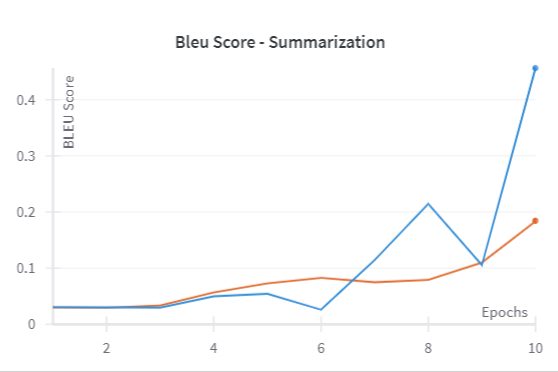

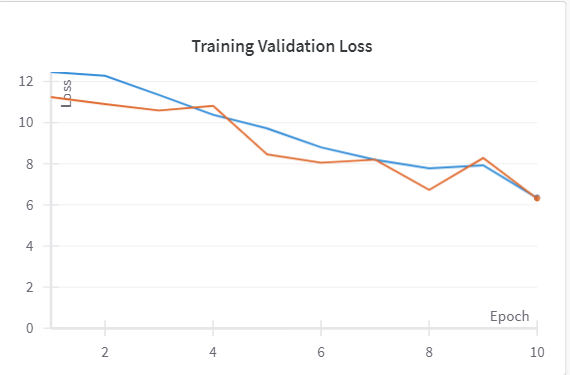

### Concept of Soft Prompts: 
####  How does the introduction of ”soft prompts” address the limitations of discrete text prompts in large language models? Why might soft prompts be considered a more flexible and efficient approach for task-specific conditioning? 
- Soft prompts are a novel approach to prompt engineering that involves incorporating vectors into an input sequence and then fine-tuning these vectors while keeping the rest of the pre-trained model’s components unchanged
- Unlike traditional human-readable prompts, which provide clear instructions expressed in human languages, soft prompts involve incorporating vectors that are very much abstract and random. Therefore, even though these vectors guide the model’s behavior, their non-linguistic nature makes it very hard for humans to understand them.
- Soft prompts are considered a more flexible and efficient approach for task-specific conditioning because they allow for more fine-grained control over the model’s behavior and can be adapted to a wide range of tasks 1.

### Scaling and Efficiency in Prompt Tuning:
#### How does the efficiency of prompt tuning relate to the scale of the language model? Discuss the implications of this relationship for future developments in large-scale language models and their adaptability to specific tasks?
- The efficiency of prompt tuning is directly related to the scale of the language model. As the size of the model increases, prompt tuning becomes more competitive with model tuning 
- In other words, larger models can be more efficiently fine-tuned using soft prompts than smaller models. This has important implications for future developments in large-scale language models and their adaptability to specific tasks. By leveraging the power of scale, prompt tuning can help to improve the performance of machine learning models without requiring extensive reprogramming or retraining 
- However, it is important to find the right balance between model size and prompt tuning performance, as scaling affects prompt tuning like a tailored suit—too loose, and it won’t hold; too tight, and it restricts movement